In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from statsmodels.stats import weightstats as stests
sns.set(style="whitegrid", palette="pastel", color_codes=True)

In [2]:
df = pd.read_csv('../spotify_cleaned.csv')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.head()

,danceability,duration_ms,energy,loudness,mode,target,tempo,valence
0,0.706,225947,0.537,-6.347,1,1,203.746,0.775
1,0.652,249960,0.621,-8.677,0,1,169.983,0.661
2,0.609,228707,0.445,-9.129,1,1,118.393,0.166
3,0.593,273053,0.680,-5.556,1,1,84.547,0.483
4,0.783,229800,0.758,-2.663,0,1,89.434,0.780


# Normality

The normality of most of the features was confirmed in the previous step of this project, however we still have to confirm the normality of the only binary feature, mode.

In [5]:
#functions

#Generate 1D replicate
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#Generate multiple replicates
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

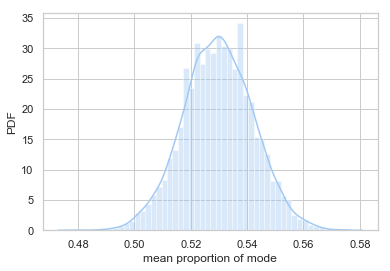

In [6]:
mode = df['mode']

## Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(mode,np.mean,10000)

# Make a histogram of the results
_ = sns.distplot(bs_replicates, bins=50)
_ = _.set(xlabel='mean proportion of mode', ylabel='PDF')

# Show the plot
plt.show()

Using bootstrapping, we can see that the probabilistic estimate of the mean proportion of mode is approximately normal.

# Is the sample size large? Are the observations independent?

In [7]:
df.shape

(1614, 8)

The sample size is sufficiently large where the Central Limit Theorem applies. The observations are independent as the audio features of one track are not dependent on another track.  The z-test will be used to test the hypotheses.

# What are the null and alternative hypotheses?

## Tempo

### H0: The mean tempo is the same for both tracks I like and tracks I dislike.

### H1: The mean tempo is different for both tracks I like and tracks I dislike

In [8]:
#split datasets based on like/dislike

liked = df.copy()
liked = liked[liked.target==1]

disliked = df.copy()
disliked = disliked[disliked.target==0]

In [9]:
tempo1 = liked['tempo']
tempo0 = disliked['tempo']

#Calculate Means
mean_1 = np.mean(tempo1)
print('Liked tempo mean: ',mean_1)            
            
mean_0 = np.mean(tempo0)
print('Disliked tempo mean: ',mean_0)

Liked tempo mean:  117.69199045346068
Disliked tempo mean:  119.39181829896906


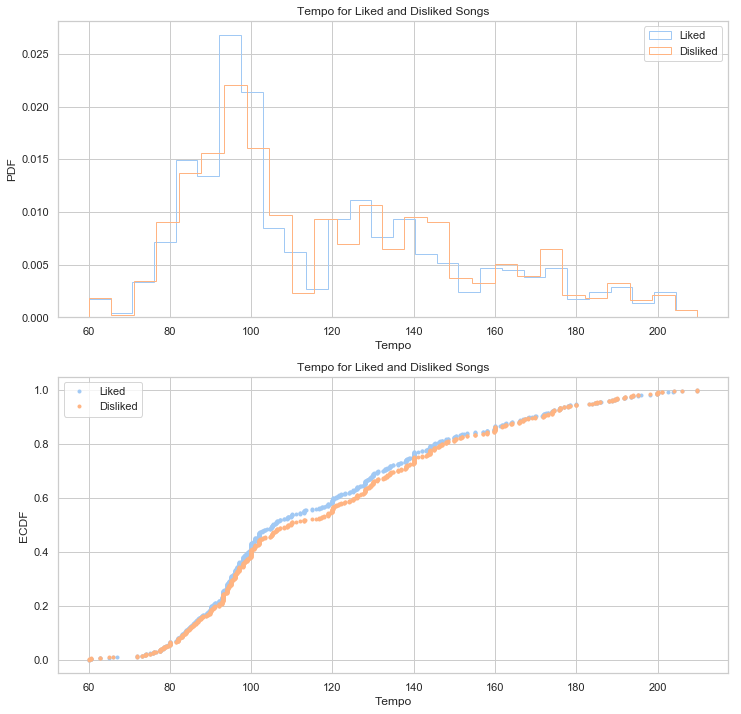

In [10]:
#Visualization

liked_bins = int(np.sqrt(len(tempo1)))
disliked_bins = int(np.sqrt(len(tempo0)))

#Compute ECDFs
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# ECDF 
liked_x, liked_y = ecdf(tempo1)
disliked_x, disliked_y = ecdf(tempo0)


# Plot
fig = plt.figure(figsize=(12, 12))
_ = plt.subplot(2,1,1)
_ = plt.hist(tempo1, bins = liked_bins, density=True, histtype='step')
_ = plt.hist(tempo0, bins = disliked_bins, density=True, histtype='step')
_ = plt.xlabel('Tempo')
_ = plt.ylabel('PDF')
_ = plt.title('Tempo for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

_ = plt.subplot(2,1,2)
_ = plt.plot(liked_x, liked_y, marker = '.',linestyle='none')
_ = plt.plot(disliked_x, disliked_y, marker = '.',linestyle='none')
_ = plt.xlabel('Tempo')
_ = plt.ylabel('ECDF')
_ = plt.title('Tempo for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

In [11]:
print('Liked Tempo Standard Deviation: ', np.std(tempo1))
print('Disliked Tempo Standard Deviation: ', np.std(tempo0))

Liked Tempo Standard Deviation:  32.73688861047879
Disliked Tempo Standard Deviation:  32.90196807914627


Looking at the histogram and the observed difference of means, the mean tempo of disliked songs are slightly less than that of disliked songs. The standard deviations are extremely close.

In [13]:
# Function to create permutation sample from two data sets
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

# Function to draw N size permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

# Test statistic
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of observed mean tempo
diff_means = diff_of_means(tempo1,tempo0)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(tempo1,tempo0,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(abs(perm_replicates) >= abs(diff_means)) / len(perm_replicates)

print('Observed difference:',diff_means)
print('P-Value:',p)

Observed difference: -1.6998278455083806
P-Value: 0.3012


#### Statistical significance for α = .05

The p-value is much higher than alpha, indicating there is no statistically significant difference in tempo between the songs I like and those I dislike.

## Danceability

### H0: The mean danceability is the same for both tracks I like and tracks I dislike.
### H1: The mean danceability is different for both tracks I like and tracks I dislike.

In [25]:
dance1 = liked['danceability']
dance0 = disliked['danceability']

#Calculate Means
mean_1 = np.mean(dance1)
print('Liked tempo mean: ',mean_1)            
            
mean_0 = np.mean(dance0)
print('Disliked tempo mean: ',mean_0)

Liked tempo mean:  0.6979886634844867
Disliked tempo mean:  0.6861295103092785


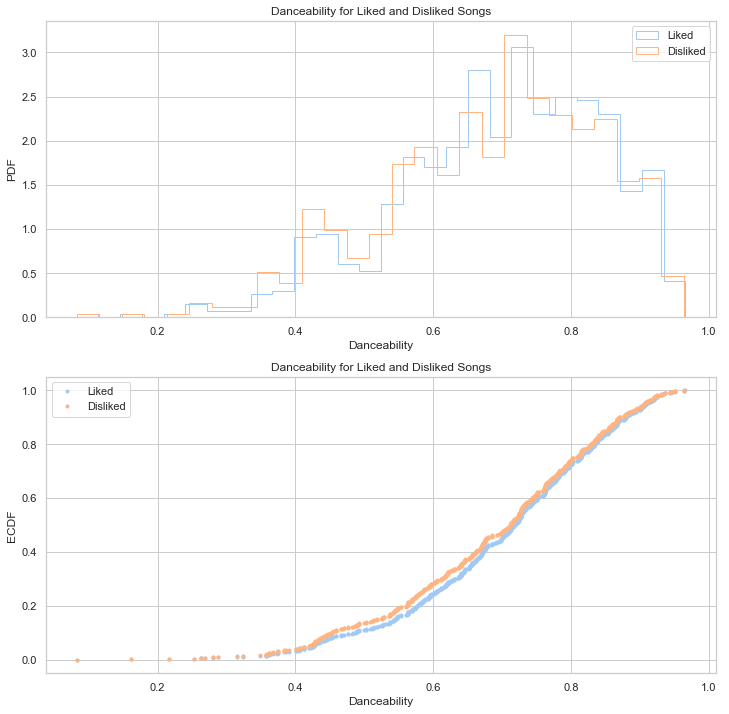

In [26]:
# ECDF 
liked_x, liked_y = ecdf(dance1)
disliked_x, disliked_y = ecdf(dance0)


# Plot
fig = plt.figure(figsize=(12, 12))
_ = plt.subplot(2,1,1)
_ = plt.hist(dance1, bins = liked_bins, density=True, histtype='step')
_ = plt.hist(dance0, bins = disliked_bins, density=True, histtype='step')
_ = plt.xlabel('Danceability')
_ = plt.ylabel('PDF')
_ = plt.title('Danceability for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

_ = plt.subplot(2,1,2)
_ = plt.plot(liked_x, liked_y, marker = '.',linestyle='none')
_ = plt.plot(disliked_x, disliked_y, marker = '.',linestyle='none')
_ = plt.xlabel('Danceability')
_ = plt.ylabel('ECDF')
_ = plt.title('Danceability for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

In [27]:
print('Liked Tempo Standard Deviation: ', np.std(dance1))
print('Disliked Tempo Standard Deviation: ', np.std(dance0))

Liked Tempo Standard Deviation:  0.1491648914712074
Disliked Tempo Standard Deviation:  0.15465954976253454


In [33]:
# Compute difference of observed mean tempo
diff_means = diff_of_means(dance1,dance0)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(dance1,dance0,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(abs(perm_replicates) >= abs(diff_means)) / len(perm_replicates)

print('Observed difference:',diff_means)
print('P-Value:',p)

Observed difference: 0.011859153175208248
P-Value: 0.116


#### Statistical significance for α = .05

The p-value is 0.116, indicating there is not a statistically significant difference between the mean danceability of songs I like and those I dislike.

## Valence

### H0: The mean valence is the same for both tracks I like and tracks I dislike.
### H1: The mean valence is different for both tracks I like and tracks I dislike.

In [29]:
valence1 = liked['valence']
valence0 = disliked['valence']

#Calculate Means
mean_1 = np.mean(valence1)
print('Liked tempo mean: ',mean_1)            
            
mean_0 = np.mean(valence0)
print('Disliked tempo mean: ',mean_0)

Liked tempo mean:  0.6239782816229116
Disliked tempo mean:  0.6139507731958762


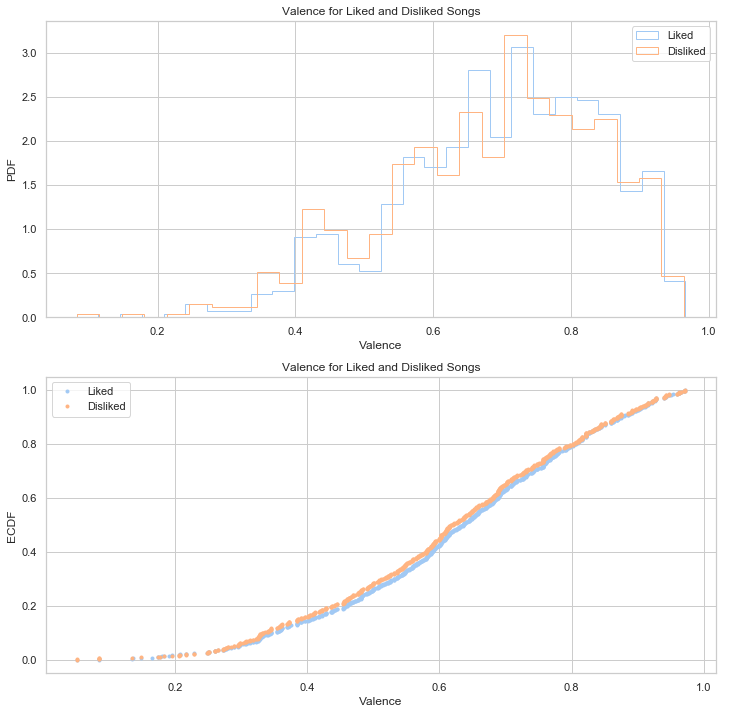

In [30]:
# ECDF 
liked_x, liked_y = ecdf(valence1)
disliked_x, disliked_y = ecdf(valence0)


# Plot
fig = plt.figure(figsize=(12, 12))
_ = plt.subplot(2,1,1)
_ = plt.hist(dance1, bins = liked_bins, density=True, histtype='step')
_ = plt.hist(dance0, bins = disliked_bins, density=True, histtype='step')
_ = plt.xlabel('Valence')
_ = plt.ylabel('PDF')
_ = plt.title('Valence for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

_ = plt.subplot(2,1,2)
_ = plt.plot(liked_x, liked_y, marker = '.',linestyle='none')
_ = plt.plot(disliked_x, disliked_y, marker = '.',linestyle='none')
_ = plt.xlabel('Valence')
_ = plt.ylabel('ECDF')
_ = plt.title('Valence for Liked and Disliked Songs')
_ = plt.legend(('Liked', 'Disliked'))

In [31]:
print('Liked Tempo Standard Deviation: ', np.std(valence1))
print('Disliked Tempo Standard Deviation: ', np.std(valence0))

Liked Tempo Standard Deviation:  0.19169429111658273
Disliked Tempo Standard Deviation:  0.19437660490780423


In [38]:
# Compute difference of observed mean tempo
diff_means = diff_of_means(valence1,valence0)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(valence1,valence0,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(abs(perm_replicates) >= abs(diff_means)) / len(perm_replicates)

print('Observed difference:',diff_means)
print('P-Value:',p)

Observed difference: 0.01002750842703537
P-Value: 0.2925


#### Statistical significance for α = .05

The p-value is 0.29, indicating there is not a statistically significant difference between the mean danceability of songs I like and those I dislike.